# Data Loading and Preprocessing

In [1]:
from autoencoder import *
import glob
from IPython.display import Audio, SVG
import visualkeras

2022-12-09 22:14:37.715225: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 22:14:37.718779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 22:14:37.718794: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_audio(filepaths, num_vectors=100, sr=22050):
    """
    Currently really slow: approximately 34 files read per second, but there are
    over 100,000 files
    """
    zipped_fname = f"raw_audio_{sr}.zip"
    audio_fname = f"raw_audio_{sr}.npy"
    audio = []
    np.random.shuffle(filepaths)
    start = time.time()
    random_indices = [i for i in range(num_vectors)]
    np.random.shuffle(random_indices)
    '''with ProcessPoolExecutor(max_workers=3) as exe:
        completed = exe.map(get_single_file, filepaths[:num_vectors], repeat(sr), chunksize=40)
        for item in completed:
            if item.shape[0] == sr:
                audio.append(item)'''
    if os.path.isfile(zipped_fname):
        with zipfile.ZipFile(zipped_fname, "r") as zip_ref:
            with zip_ref.open(audio_fname) as unzipped:
                audio = np.load(unzipped)
                print(time.time() - start)
                return audio[random_indices]
    for i, path in enumerate(filepaths):
        if i >= num_vectors:
            break
        X, sample_rate = librosa.load(path, sr=sr)
        if X.shape[0] != sample_rate:
            X = librosa.util.fix_length(X, size=sr)
        audio.append(X)
    print(time.time() - start)
    with zipfile.ZipFile(zipped_fname, "w") as zip_ref:
        np.save(audio_fname.replace(".npy", ""), audio)
        zip_ref.write(audio_bfname)
    return np.array(audio, dtype=np.float32)[random_indices]

In [3]:
sr = 8000
n_mels = 128
fix_length=44
filepaths = get_all_files("wav")
audio = get_audio(filepaths, num_vectors=3000, sr=sr, )

0.12078356742858887


In [4]:
def conv_data(audio, sr, n_mels=64, fix_length=44, split=True):
    ### Long operation: convert raw audio to melspectrogram
    start = time.time()
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel = librosa.util.fix_length(mel, size=fix_length)
    print(mel.shape)
    db = librosa.amplitude_to_db(mel, ref=np.max)
    print(time.time() - start)
    ### Reshape mel spectrogram so each [row][col] is a singleton array (for keras)
    db = db.reshape(*db.shape, 1) # This may not be a good idea

    if split:
        X_train, X_test = train_test_split(db, test_size=0.3)
        return X_train, X_test
    return db

In [5]:
X_train, X_test = conv_data(audio, sr, n_mels=n_mels, fix_length=fix_length)

(3000, 128, 44)
2.1012651920318604


# Audio Visualization

In [6]:
Audio(audio[0], rate=sr)

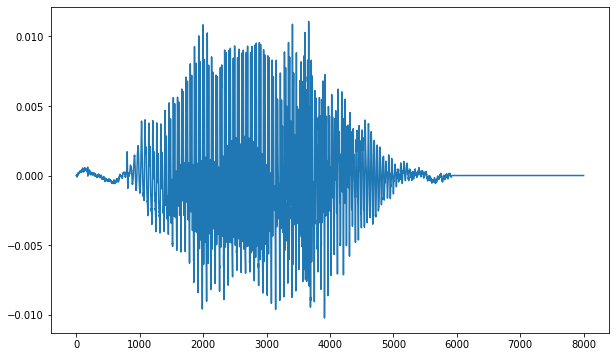

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(audio[0])

(128, 16)

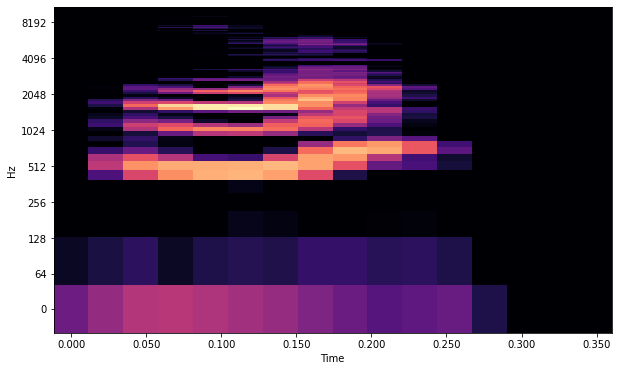

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
index = np.random.randint(0, len(audio))
mel = librosa.feature.melspectrogram(y=audio[0], sr=sr, n_mels=n_mels)
mel_to_db = librosa.amplitude_to_db(mel, ref=np.max)
librosa.display.specshow(mel_to_db, x_axis="time", y_axis="log", ax=ax)
reshaped = mel.reshape(*mel.shape, 1)
fig.savefig("asdf.png")
mel.shape

# Get Convolutional Model

In [9]:
def get_conv_model(input_shape, latent):
    Input = tf.keras.Input(shape=input_shape)
    #encoder = Sequential()
    x = layers.Conv2D(2 * latent, (3, 3), activation="leaky_relu", padding="same", input_shape=input_shape)(Input)
    x = layers.MaxPool2D((2, 2), padding="same")(x)
    x = layers.Conv2D(latent, (3, 3), activation="leaky_relu", padding="same")(x)
    #print(encoder.summary())
    #latent = encoder(Input)
    #decoder = Sequential()
    x = layers.Conv2DTranspose(latent * 2, (3, 3), strides=2, activation="leaky_relu", padding="same")(x)
    x = layers.Conv2D(1, (1, 1), activation="linear")(x)
    print(x.shape)
    #print(decoder.summary())

    model = Model(inputs=Input, outputs=x)
    print(model.summary())
    model.compile(optimizer="adam", loss="MSE")
    return model

In [10]:
latent = 32
print(X_train.shape[1:])
mel_autoencoder_model = get_conv_model(X_train.shape[1:], latent)

(128, 44, 1)
(None, 128, 44, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 44, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 128, 44, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 22, 32)        18464     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 44, 64)      18496     
 nspose)                                                         
                                                                 
 conv2d_2 (Conv2D)           

2022-12-09 22:14:42.367882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-09 22:14:42.367915: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 22:14:42.367941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jonaz-17Z90N-R-AAC8U1): /proc/driver/nvidia/version does not exist
2022-12-09 22:14:42.368397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
X_train.shape

(2100, 128, 44, 1)

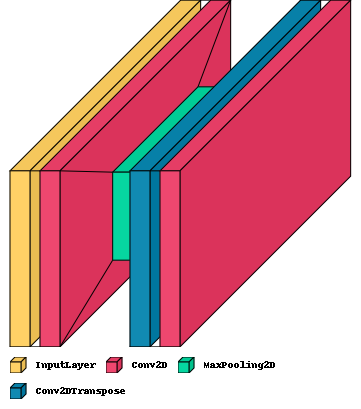

In [12]:
visualkeras.layered_view(mel_autoencoder_model, legend=True, draw_volume=True)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.2164

INFO:tensorflow:Assets written to: models/mel_8000_128_44_<function mean_squared_error at 0x7f80ee38bdc0>/assets


INFO:tensorflow:Assets written to: models/mel_8000_128_44_<function mean_squared_error at 0x7f80ee38bdc0>/assets


40/40 [==============================] - 8s 187ms/step - loss: 0.2164 - val_loss: 0.1904
Epoch 2/10
40/40 [==============================] - 7s 184ms/step - loss: 0.4920 - val_loss: 0.5658
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.2293

INFO:tensorflow:Assets written to: models/mel_8000_128_44_<function mean_squared_error at 0x7f80ee38bdc0>/assets


INFO:tensorflow:Assets written to: models/mel_8000_128_44_<function mean_squared_error at 0x7f80ee38bdc0>/assets


40/40 [==============================] - 8s 208ms/step - loss: 0.2293 - val_loss: 0.1831
Epoch 4/10
40/40 [==============================] - 8s 200ms/step - loss: 0.1822 - val_loss: 0.2490
Epoch 5/10
40/40 [==============================] - 8s 200ms/step - loss: 0.4114 - val_loss: 0.1951
Epoch 6/10
40/40 [==============================] - 9s 233ms/step - loss: 0.2394 - val_loss: 0.4765
Epoch 7/10
40/40 [==============================] - 8s 204ms/step - loss: 0.2544 - val_loss: 0.1985
Epoch 8/10
40/40 [==============================] - 8s 206ms/step - loss: 0.5360 - val_loss: 0.3256
Epoch 9/10
40/40 [==============================] - ETA: 0s - loss: 0.1926

INFO:tensorflow:Assets written to: models/mel_8000_128_44_<function mean_squared_error at 0x7f80ee38bdc0>/assets


INFO:tensorflow:Assets written to: models/mel_8000_128_44_<function mean_squared_error at 0x7f80ee38bdc0>/assets


40/40 [==============================] - 9s 221ms/step - loss: 0.1926 - val_loss: 0.1757
Epoch 10/10
40/40 [==============================] - 8s 209ms/step - loss: 0.2635 - val_loss: 0.2230


(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:title={'center':'mel_8000_128_44_<function mean_squared_error at 0x7f80ee38bdc0>'}, xlabel='epoch', ylabel='loss'>)

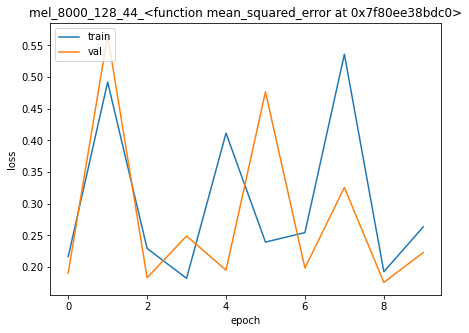

In [38]:
model_name = f"mel_{sr}_{X_train.shape[1]}_{X_train.shape[2]}_{mel_autoencoder_model.loss}"
checkpoint_callback = get_checkpoint(model_name)
history = mel_autoencoder_model.fit(X_train, X_train, epochs=10, batch_size=48, shuffle=True, callbacks=[checkpoint_callback], validation_split=0.1)
plot_history(model_name, history, "loss")

# Predict and Convert to Audio

In [39]:
mel_autoencoder_model = tf.keras.models.load_model(os.path.join("models", model_name))
pred = mel_autoencoder_model.predict(X_test)

29/29 [==============================] - 1s 43ms/step


# Compare Spectrograms of Predicted vs. Actual

In [40]:
reshaped_pred = pred.reshape(pred.shape[:-1])
reshaped_actual = X_test.reshape(X_test.shape[:-1])

## Spectrogram Stats

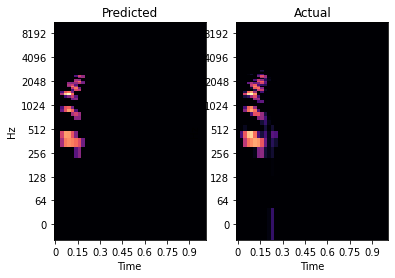

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Predicted")
ax2.set_title("Actual")
index = np.random.randint(0, len(reshaped_pred))
diff = np.abs(reshaped_pred[index]) - 80
filtered = np.abs(diff) < 10
res = filtered * diff + reshaped_pred[index]
librosa.display.specshow(res, x_axis="time", y_axis="log", ax=ax1)
librosa.display.specshow(reshaped_actual[index], x_axis="time", y_axis="log", ax=ax2)
fig.savefig("asdf.png")


In [47]:
amp_pred = librosa.db_to_amplitude(res)
amp_actual = librosa.db_to_amplitude(reshaped_actual[index])
audio_pred = librosa.feature.inverse.mel_to_audio(amp_pred, sr=sr)
audio_actual = librosa.feature.inverse.mel_to_audio(amp_actual, sr=sr)
print(np.min(audio_pred))
print(np.min(audio_actual))

-0.005943616
-0.00404328


In [48]:
sf.write("best.wav", audio_pred * 200, sr)
print(sr)
Audio(audio_pred, rate=sr)

8000


In [49]:
mel = librosa.feature.melspectrogram(y=audio[index], sr=sr, n_mels=n_mels)
db = librosa.amplitude_to_db(mel, ref=np.max)
amp = librosa.db_to_amplitude(db)
out = librosa.feature.inverse.mel_to_audio(amp, sr=sr)
Audio(out, rate=sr)

# Try Different Numbers (Measure Loss/Anomaly Detection)

In [50]:
files = get_all_files("wav", False)

In [51]:
random_files = np.random.choice(files, 20)
print(random_files)
random_audio = []
for file in random_files:
    audio_data, rate = librosa.load(file, sr=sr)
    if audio_data.shape[0] != sr:
        audio_data = librosa.util.fix_length(audio_data, size=sr)
    random_audio.append(audio_data)
random_audio = np.array(random_audio)

['data/34/4_34_30.wav' 'data/42/9_42_16.wav' 'data/54/3_54_3.wav'
 'data/26/0_26_8.wav' 'data/58/2_58_39.wav' 'data/50/9_50_23.wav'
 'data/03/9_03_2.wav' 'data/46/7_46_11.wav' 'data/52/6_52_19.wav'
 'data/43/7_43_37.wav' 'data/42/5_42_20.wav' 'data/24/5_24_26.wav'
 'data/31/3_31_20.wav' 'data/18/9_18_32.wav' 'data/03/9_03_45.wav'
 'data/55/9_55_39.wav' 'data/28/8_28_13.wav' 'data/05/5_05_42.wav'
 'data/26/2_26_41.wav' 'data/22/8_22_33.wav']


In [52]:
index = np.random.randint(0, len(random_audio))
Audio(random_audio[index], rate=sr)

In [54]:
print(random_files[index])

data/03/9_03_2.wav


In [55]:
mels = conv_data(random_audio, sr, n_mels=n_mels, fix_length=fix_length, split=False)
print(mels.shape)

(20, 128, 44)
0.014726877212524414
(20, 128, 44, 1)


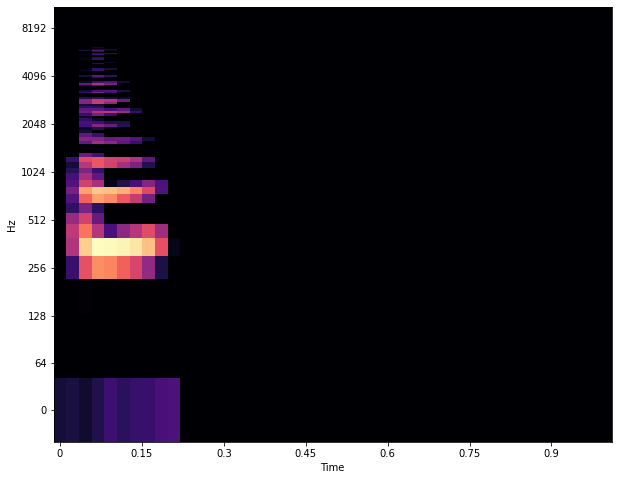

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
librosa.display.specshow(mels[index].reshape(*mels.shape[1:3]), x_axis="time", y_axis="log", ax=ax)

In [57]:
for i in range(len(random_files)):
    print(random_files[i])
    inp = np.array([mels[i]])
    mel_autoencoder_model.evaluate(inp, inp)

data/34/4_34_30.wav
1/1 [==============================] - 0s 102ms/step - loss: 0.8743
data/42/9_42_16.wav
1/1 [==============================] - 0s 22ms/step - loss: 0.7744
data/54/3_54_3.wav
1/1 [==============================] - 0s 33ms/step - loss: 0.1349
data/26/0_26_8.wav
1/1 [==============================] - 0s 21ms/step - loss: 0.3098
data/58/2_58_39.wav
1/1 [==============================] - 0s 27ms/step - loss: 0.1287
data/50/9_50_23.wav
1/1 [==============================] - 0s 29ms/step - loss: 0.5736
data/03/9_03_2.wav
1/1 [==============================] - 0s 25ms/step - loss: 0.3245
data/46/7_46_11.wav
1/1 [==============================] - 0s 23ms/step - loss: 0.1331
data/52/6_52_19.wav
1/1 [==============================] - 0s 28ms/step - loss: 0.1189
data/43/7_43_37.wav
1/1 [==============================] - 0s 29ms/step - loss: 0.2854
data/42/5_42_20.wav
1/1 [==============================] - 0s 30ms/step - loss: 1.0760
data/24/5_24_26.wav
1/1 [====================